In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

import process


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
X_train, X_val, X_test, Y_train, Y_val, Y_test, mask = process.load_data(keep_hrf_shape=True)
print(X_train.shape, Y_train.shape)

Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
torch.Size([2864, 768, 4]) torch.Size([2864, 37226])


In [4]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = [x.to(device) for x in 
                                                  [X_train, X_val, X_test, Y_train, Y_val, Y_test]]

In [5]:
class AKModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        d_in, d_out= X_train.shape[-1], Y_train.shape[-1]
        self.linear = torch.nn.Linear(d_in, d_out)
#         self.deep1 = torch.nn.Sequential(torch.nn.Linear(d_in, 1000),
#                                          torch.nn.Sigmoid(),
#                                          torch.nn.Linear(1000, 1000),
#                                          torch.nn.Sigmoid(),
#                                          torch.nn.Linear(1000, 1000),
#                                          torch.nn.Sigmoid(),
#                                          torch.nn.Linear(1000, d_out))
        
        self.deep1 = torch.nn.Sequential(torch.nn.Linear(d_in, 1000),
                                         torch.nn.Linear(1000, d_out))
        
        self.deep2 = torch.nn.Sequential(torch.nn.Linear(d_in, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, d_out))
        
        self.deep3 = torch.nn.Sequential(torch.nn.Linear(d_in, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, d_out))
        
    def forward(self, X):
#         Y = self.linear(X)
#         Y = self.linear(X) + self.deep1(X) + self.deep2(X) + self.deep3(X)
        Y = self.deep1(X) + self.deep2(X) + self.deep3(X)
#         Y = self.deep1(X) + self.deep3(X)
        return Y

class HRFAttention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        d_in, d_out= X_train.shape[-2], Y_train.shape[-1]
        self.mask = torch.nn.Sequential(torch.nn.Linear(d_in*4, 100),
                                         torch.nn.Sigmoid(),
                                         torch.nn.Linear(100, 100),
                                         torch.nn.Sigmoid(),
                                         torch.nn.Linear(100, 4),
                                         torch.nn.Softmax(dim=-1))
        
        self.deep1 = torch.nn.Sequential(torch.nn.Linear(d_in, 4000),
                                         torch.nn.Linear(4000, d_out))
        
        
        self.deep2 = torch.nn.Sequential(torch.nn.Linear(d_in, 100),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(100, d_out))
        
#         self.attmod = torch.nn.Parameter(torch.randn(4, 37226)*1e-2)
        
        
    def forward(self, X):
        X = X.permute(0,2,1) # N, hrf, D_in
#         print(X.shape)
#         X1 = X.reshape(-1, X.shape[-1]) # N*hrf, D_in
#         print(X1.shape)
        X_hrfflat = X.reshape(X.shape[0], -1) # N, hrf*D_in
#         print(X_hrfflat.shape)
        Y = self.deep1(X)
        att = self.mask(X_hrfflat)
        Y = (Y*att[..., None]).sum(dim=-2)
#         att = torch.softmax(self.attmod, dim=-2)
#         Y = (Y*att).sum(dim=-2)
        return Y

In [6]:
torch.manual_seed(0)
model = HRFAttention().to(device)
model(X_test)
print(np.sum([p.numel() for p in model.parameters()]))
# model = torch.nn.Sequential(torch.nn.Linear(delRstim.shape[-1], mask.sum())).to(device)

# opt = torch.optim.SGD(model.parameters(), lr=3e1, weight_decay=1e-4)
# opt = torch.optim.SGD(model.parameters(), lr=6e1)
opt = torch.optim.Adam(model.parameters(), lr=4e-4)

156171756


In [7]:
bs = 500
all_idxs = range(len(X_train))

for epoch_idx in tqdm(range(3)[:1000]):
    all_batch_idxs = [all_idxs[i: i+bs] for i in range(0, len(all_idxs), bs)]
    for batch_idxs in (all_batch_idxs):
        X_batch = X_train[batch_idxs]
        Y_batch = Y_train[batch_idxs]
        Y_batch_pred = model(X_batch)
    
        se, voxcorrs = process.calc_stats(Y_batch, Y_batch_pred)
#         loss = se.mean()
        loss = -voxcorrs.mean()
        
        Y_test_pred = model(X_test)
        loss_test = (Y_test-Y_test_pred).pow(2).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss = loss.detach()
        
#     mse_train, corr_train = process.calc_stats(Y_batch.detach(), model(X_batch).detach())
#     mse_val, corr_val = process.calc_stats(Y_val.detach(), model(X_val).detach())

    if epoch_idx%1==0:
        print('Training set')
        process.show_stats(Y_batch, Y_batch_pred)
        print('Validation set')
        process.show_stats(Y_val, model(X_val))
        print('Testing set')
        process.show_stats(Y_test, model(X_test))
        print()
        print()
    del Y_batch_pred, se, voxcorrs, loss

Training set
MSE: 1.11219, MC: 1.704%
Validation set
MSE: 1.11729, MC: 3.171%
Testing set
MSE: 1.11462, MC: 5.529%


Training set
MSE: 1.07399, MC: 11.879%
Validation set
MSE: 1.12267, MC: 4.315%
Testing set
MSE: 1.11971, MC: 7.807%


Training set
MSE: 0.99824, MC: 19.947%
Validation set
MSE: 1.10507, MC: 4.313%
Testing set
MSE: 1.08627, MC: 9.143%





MSE: 1.08627, MC: 9.143%


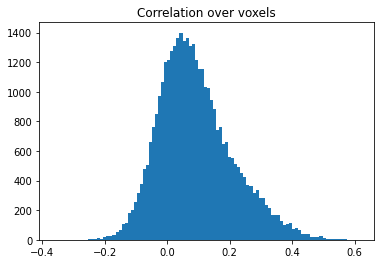

(1.0862739086151123, 0.09143078327178955)

In [8]:
process.show_stats(Y_test, model(X_test), show_vox_corr_hist=True)